In [1]:
Data_path = "D:\Huge datasets\Clash_royale\data"

In [2]:
import pandas as pd
from os import path
import json
import codecs
import ast
import numpy as np
import seaborn as sns
from itertools import chain, combinations
%matplotlib inline
Data_path = "D:\Huge datasets\Clash_royale\data"

Directly load the preprocessed dataframe (add the preprocessing pipeline for reproducibility)

In [3]:
import pickle
data = pickle.load(open(path.join(Data_path,"preprocessed_df.pkl"), "rb"))
# compute two lists to get all the possible cards played in the dataset
a = data.left_deck_list 
liste = set(chain.from_iterable(a))
liste_2 = [l+"_level" for l in liste]

In [4]:
# load card info to get elixir
cards_info = pd.read_csv(Data_path+'/info_cards.csv')

In [5]:
# map elixir to each card
map_elixir = lambda x: [int(cards_info.loc[cards_info.name==a,"elixir"]) for a in x]

In [6]:
elixir_list = data.left_deck_list.map(map_elixir)
elixir_mean = elixir_list.map(np.mean)

In [7]:
# compute mean of elixir (the objective was to find the optimal mean level of elixir: no robust results obtained)
elixir_mean = elixir_list.map(np.mean)
data['elixir_mean'] = elixir_mean

questions: 
    - what's the impact of one card level on performance'
    - what's the rarity optimal rarity level
    - what is the relationship between elixir mean and performance (find optimal level of elixir)
    - give personnal stats on past few games/Decks

# Build one feature per card

In [8]:
from collections import Counter
def map(deck):
    s = Counter(deck)
    res = {k:s[k] for k in liste}
    return res
flat_deck = data.left_deck_list.map(lambda x: map(x))
cards = pd.DataFrame(list(flat_deck))

# Build one feature per level

In [9]:
%%time

def map_again(tup):
    classe = {v:int(k) for k,v in tup}
    dico = {k:(classe[k.split("_")[0]] if k.split("_")[0] in classe else 0) for k in liste_2}
    return dico

format_row = lambda x: list(zip(x['left_level_list'], x["left_deck_list"]))

merged = data.apply(lambda x: format_row(x), axis=1)
marged = merged.map(map_again)

Wall time: 1min 4s


In [10]:
levels = pd.DataFrame(list(marged))

In [11]:
# concatenate all features (aroound 200 features at the end, seems reasonable compared to nb of lines)
X = pd.concat([cards, levels, data.mean_trophies, elixir_mean],axis=1)

In [12]:
# prepare targets for 4 different regressions (3 ordinal logit, and one Binary Logistic)
# the coefficients obtained cannot directly be interpreted in odds ratio (marginal probability), but their amount does not really matter, their comparison
#only is important (add odds ratio later)

y_diff = data.left_diff #ordinal (crowns won - crowns lost) (from -3 to +3)
y_attack = data.left_crowns # ordinal: crowns won: from 0 to 3
y_defense = data.left_crowns - data.left_diff # ordinal crowns lost: from 0 to 3
y_won = data.left_diff > 0 # logistic regression: True/False
targets = [y_diff, y_attack, y_defense, y_won]

In [13]:
%%time
from sklearn.linear_model import LogisticRegression
import mord
# train the models (would be good to add crossvalidation? not sure)

lrs = [mord.LogisticAT(verbose=1) for l in range(len(targets)-1)]
lrs.append(LogisticRegression(n_jobs=-1,C=1e9))
models = [lr.fit(X,t) for t, lr in zip(targets, lrs)]  

b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
Wall time: 43min 2s


In [14]:
# gather coefficients for each regression
coef_dict = [{k:v for k,v in zip(X.columns, m.coef_)} for m in models[:-1]]
coef_dict.append({k:v for k,v in zip(X.columns, models[-1].coef_[0])})

In [15]:
# map coefs to dictionnaries
coefs_cards = [{k:v for k,v in d.items() if k in liste} for d in coef_dict]
coefs_level = [{k:v for k,v in d.items() if k in liste_2} for d in coef_dict]
coefs_level = {k.split('_')[0]:v for k,v in coefs_level[0].items()} # take just diff regression parameters for coefs
coefs_cards.append(coefs_level)

In [16]:
# create a dict key: cards values: dict of results

from collections import defaultdict
final_dic = defaultdict(dict)
for dico, attribute in zip(coefs_cards,["perf","attack","defense","win_ratio","level_bonus"]):
    for card in dico.keys():
        final_dic[card][attribute] = dico[card]

just save file to disk

In [17]:
import json
out_file = open(path.join(Data_path,"informative_results/informative_regression.json"),"w")
json.dump(final_dic, out_file,indent=0)
out_file.close()

### interpretation:
   * Performance: the presence of card x, increases the probability of having +1 in difference of crowns  (crown wons - crowns lost) by n % (n being the value in the json).
   * Attack & Defense: The Presence of the card x in deck, increases the probability to destroy/lose one crown by n %
   * win_ratio: The Presence of the card x in deck increases the  chance of winning the game by n % (independantly of the number of crowns)
   * level_bonus: adding one level to the specific card will increase the difference of crowns by n %, it's probably wise to only compare value of cards sharing the same rarity (common with common, epic with epic...) since the level of different rarity is more difficult to obtain.
   

In order to know which card to invest in,  it would be appropriate to make a ratio gain in performance (measured by level_bonus and cost to achieve the level upgrade. (express this cost in a comparable unit between level of rarity...)

---
   
Notes: 
- some of the results might not be robust (since fewer games were played with those specific cards), some indicator of robustness can be computed (bootstraped confidence intervals...), notheless the results obtained for win_ratio and perf are very likely to be robust (thousands of games for those cards)
- these results may only be valid for good players (only above 3500 included in the analysis)
- the analysis should be performed again after a change in the characterstic of a card.

In [18]:
def plotting_result(series, name = '', col ="b"):
    pd.Series(series).sort_values().plot(kind = "barh", figsize = (8,15), color =col,title = name);

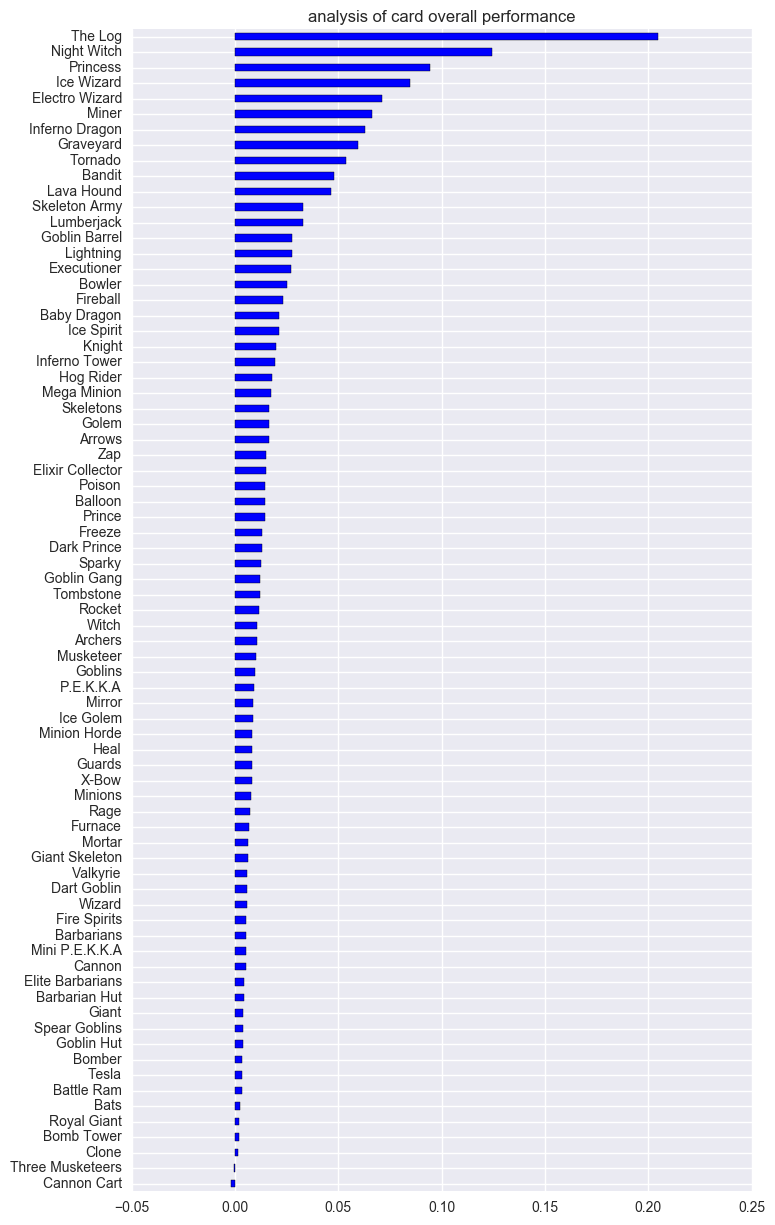

In [19]:
plotting_result(coefs_cards[0], "analysis of card overall performance")

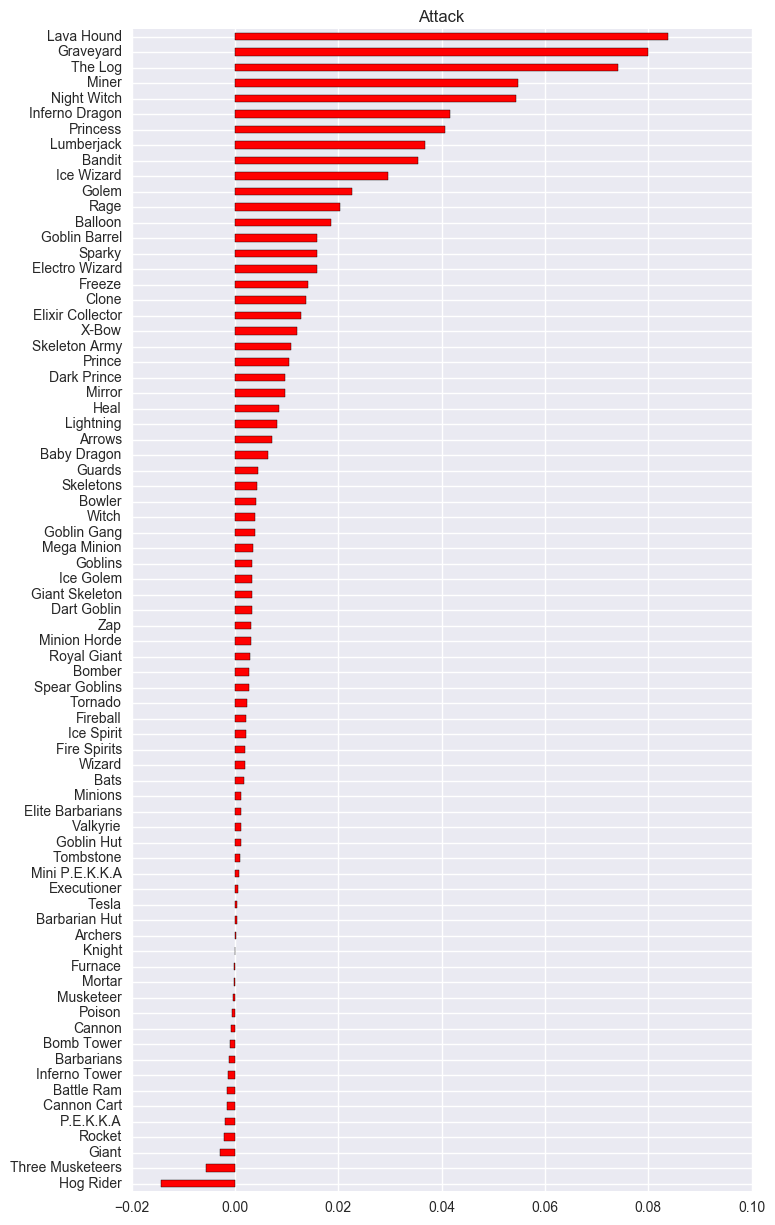

In [20]:
plotting_result(coefs_cards[1],"Attack", 'red') 
# note: attack analysis just measure the number of towers destroyed, when this card is in the deck 

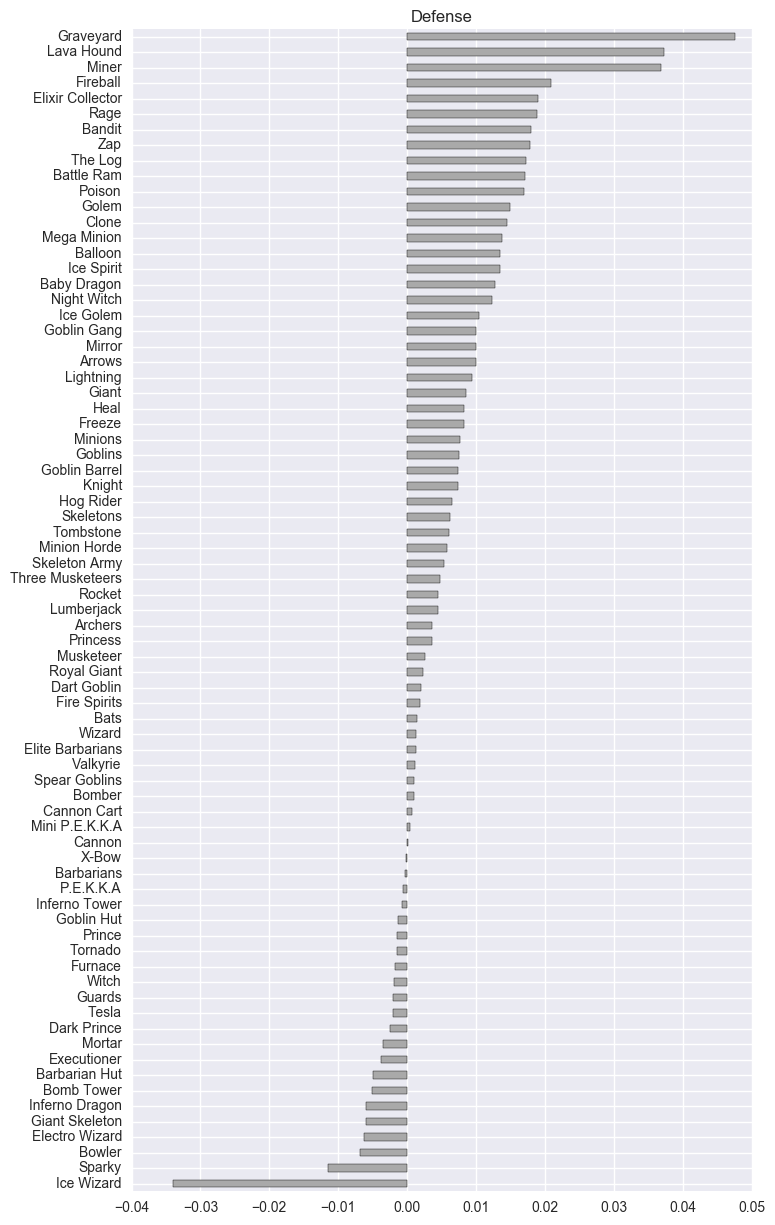

In [21]:
plotting_result(coefs_cards[2],"Defense","darkgrey")

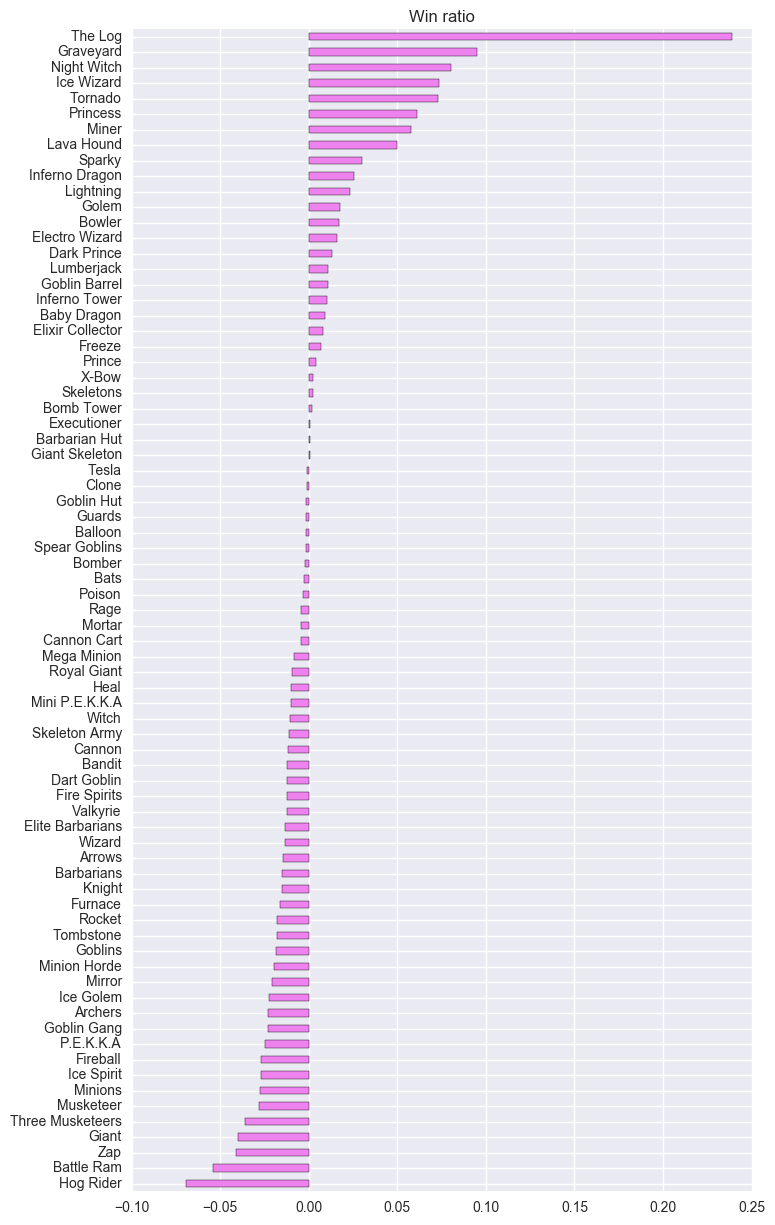

In [22]:
plotting_result(coefs_cards[3], "Win ratio","violet")

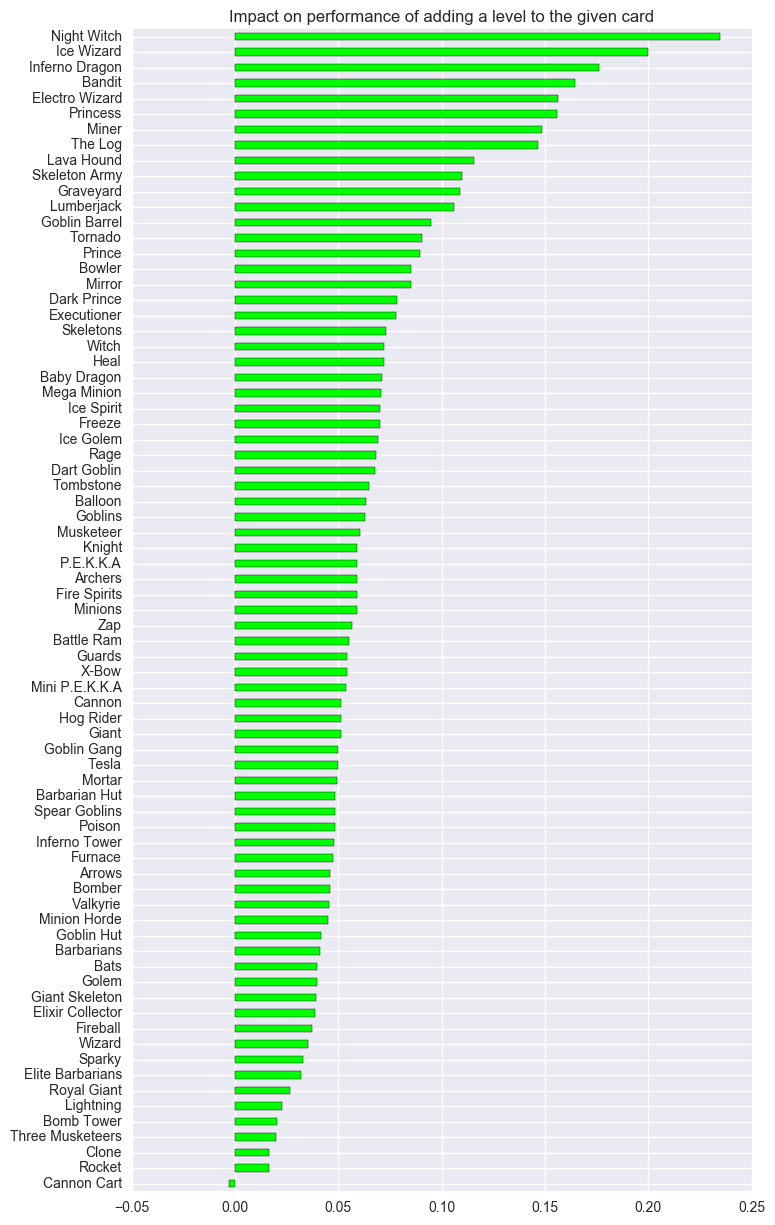

In [23]:
plotting_result(coefs_level, "Impact on performance of adding a level to the given card", "lime")

In [24]:
pprint(final_dic)

Pretty printing has been turned OFF


In [32]:
import matplotlib.image as mpimg
import matplotlib.pylab as plt

In [33]:
from matplotlib.offsetbox import (OffsetImage,AnnotationBbox)

In [34]:
import glob
image_path = glob.glob(Data_path+"/images/*.png")
images = {i.split('\\')[-1].split('.png')[0].title() : mpimg.imread(i,format="png") for i in image_path}
images["Mini-PEKKA"] = images["Mini-Pekka"]
images["PEKKA"] = images["Pekka"]

In [45]:
def res_plot(data, images,title = ""):
    f, ax = plt.subplots(figsize = (8,35))
    plt.style.use('seaborn-white')
    dat = pd.Series(data).sort_values()
    sorted_images = [images[i.replace(' ','-').replace('.','')] for i in dat.index]
    my_range = range(len(dat.index))
    ax.hlines(y=my_range, xmin=0, xmax=dat.values, color='skyblue',linewidth = 3)
    #ax.plot(dat, my_range, "o",color='r',markersize = 10)
    ax.set_ylim(-1,76 )
    ax.set_xlim(None,max(dat) +0.05)
    ax.set_title(title)
    ax.grid(color='r', linestyle='--', linewidth=1)
    b=0
    for image,y, x in zip(sorted_images, my_range, dat.values):
        build_artist(ax, image, [x , y-0.5])
        b+=0.001

In [46]:
def build_artist(ax, image, xy):
    im = OffsetImage(image, zoom=0.1)
    im.image.axes = ax
    ab = AnnotationBbox(im, xy, pad=0,
                        xycoords='data',
                        frameon=False,
                        box_alignment =(0,0))
    ax.add_artist(ab)

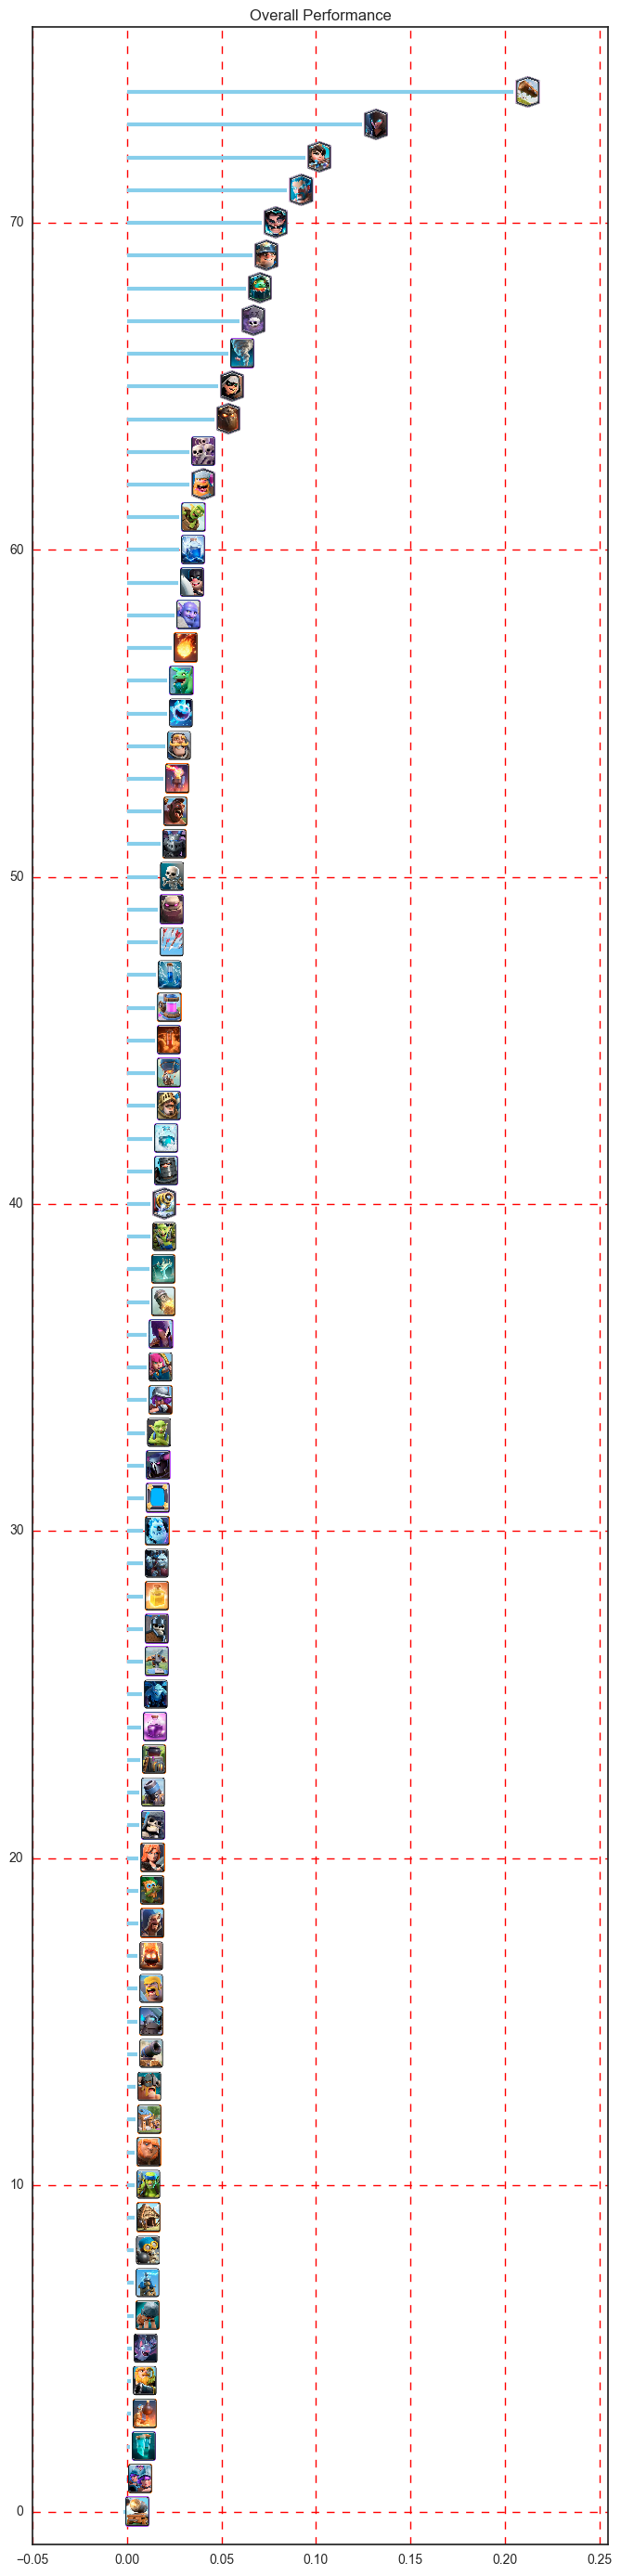

In [47]:
res_plot(coefs_cards[0], images ,title="Overall Performance")

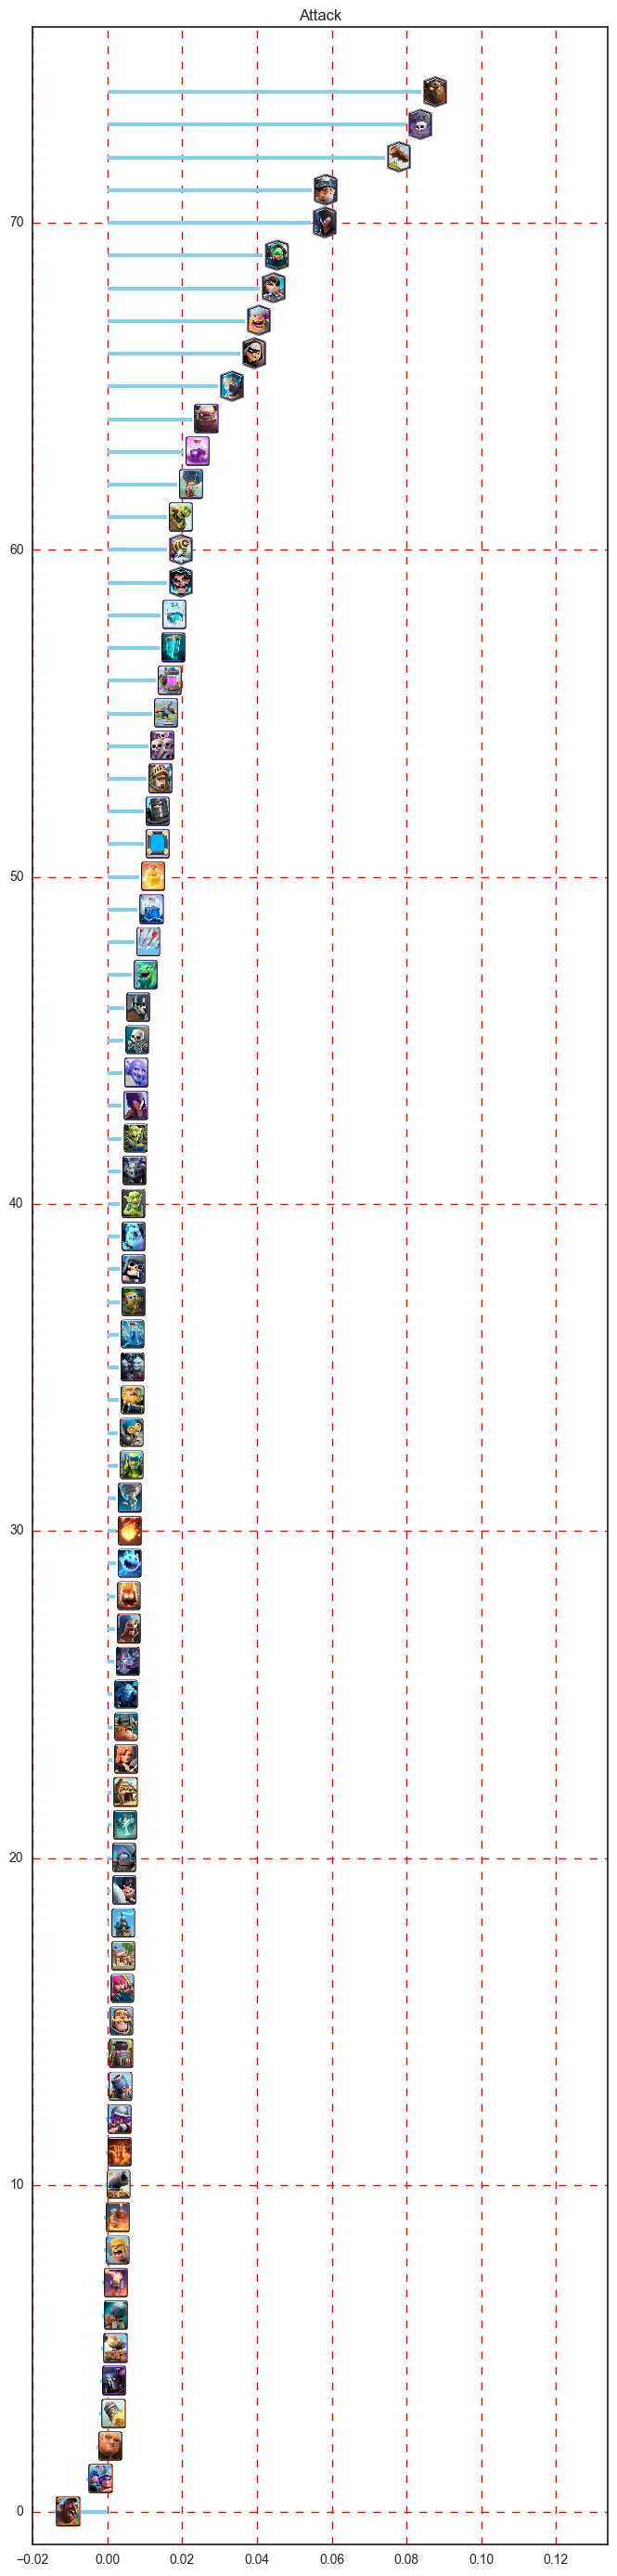

In [49]:
res_plot(coefs_cards[1], images=images,title= 'Attack')

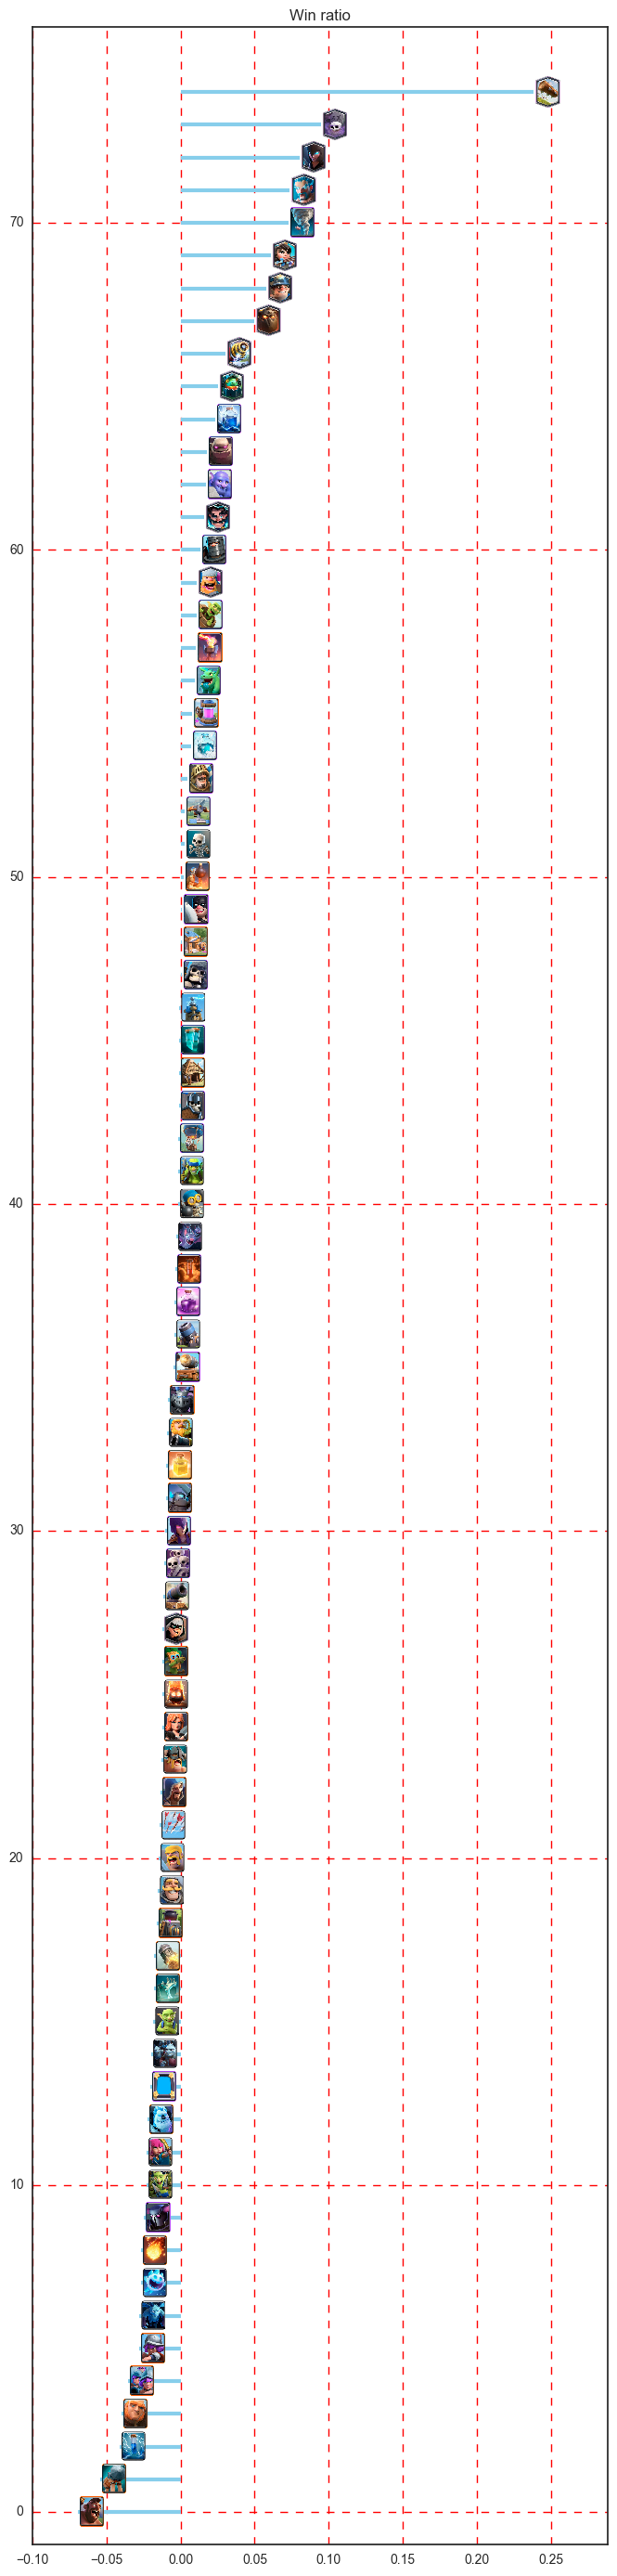

In [50]:
res_plot(coefs_cards[3], images=images,title= 'Win ratio')

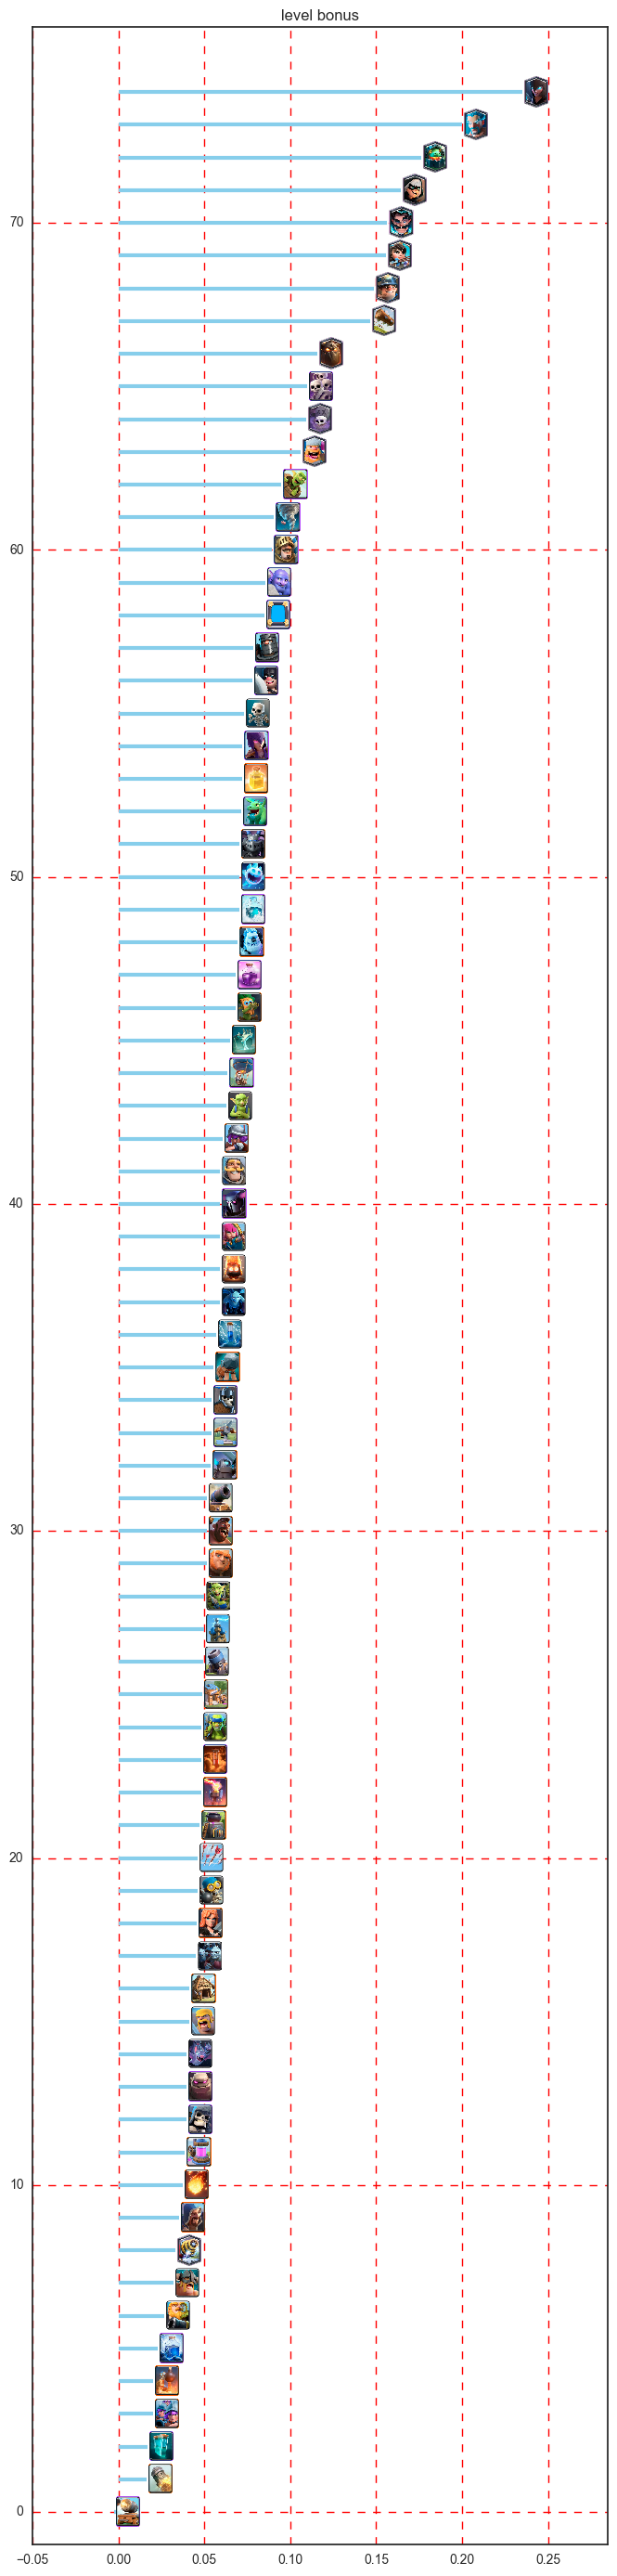

In [52]:
res_plot(coefs_level, images=images,title= 'level bonus')